Instacart Challenge -- JT 20180929
--

## Summary

The data challenge is to predict shopping time. I have train_trips.csv, test_trips.csv and order_items.csv. In the order_items.csv, there are information about items, department and quantity for each trip. These information in order_items.csv need to be joined with train_trips.csv and test_trips.csv. After exploring and understanding the data, I joined order_items.csv with train_trips.csv and test_trips.csv. Then I did feature engineering to create some useful features. Next, I did model training and prediction. This is a regression problem. I tried Random Forest and XGBoost models here with hyperparamter tuning. For the final results, I used XGBoost as it gave better results. 

## Steps

### Read in data, explore data and understand data

  - Read in the three csv files, understand number of records, features, missing values, distributions, etc.

  - There is no missing value. 
  
  - There is -0.75 and -0.5 for item quantity in order_items.csv, I assume it should be 1 and do data imputation. 

### Feature engineering

  - Get number of types of items, number of types of departments and total quantities of items for each of the trips in order_items.csv.
  
    - Total number of item types. How many types of items each trip includes will affect shopping time.
    - Total number of department types. The assumption is that the shopper shops at one department will spend less time compared to another shopper who shops at 5 departments.
    - Total quantity of items. 

  - Do feature engineering for train_trips.csv and test_trips.csv for fulfillment_mode, store_id, and shopping_started_at.
  
    - Weekday and Hour. What day of the week and what hour of the day will be important features to determine the shopping time.
    - fulfillment_mode, dummy variables for each model 
    - store_id, dummy variables for each store

  - Join datasets between train_trips.csv/test_trips.csv and order_items.csv.

### Model training, hyperparameter tuning and prediction
 
This is a regression problem. Two models are tried here: random forest regression and XGBoost regression. Random forest regression is a good out of box model for regression which can include interactions among features. XGBoost is a more powerful ensemble based tree model which has been shown to be very powerful for a lot of macchine learning problems. As we goal here is to predict shopping_time more accurately, XGBoost has been chosen to do the final hyperparameter tuning and prediction. Randomized search is conducted with cross validation to do hyperparamter tuning. The best tuned model is used for prediction.

## Notes

### Choose of metric

This is a regression problem. I can choose 'MSE' or 'MAE' as the metric. RMSE should be more useful when large errors are particularly undesirable. When we predict shopping time, we do not want to have large errors, so I choose to use MSE here as my metric.

### Estimation of shopping time

Just like estimation of time of arrival for rides of Uber or Lyft, the estimation of shopping time is very hard to be accurate. More data and more information about each of the shopping trip will help to improve the model accuracy.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

### Read in data, explore data and understand data

In [2]:
# Read in dataset

train = pd.read_csv('./instacart-picking-time-challenge-data/train_trips.csv')
order = pd.read_csv('./instacart-picking-time-challenge-data/order_items.csv')
test = pd.read_csv('./instacart-picking-time-challenge-data/test_trips.csv')

In [3]:
train.head(3)

,trip_id,shopper_id,fulfillment_model,store_id,shopping_started_at,shopping_ended_at
0,3119519,48539,model_1,6,2015-09-01 07:03:56,2015-09-01 07:30:56
1,3119513,3775,model_1,1,2015-09-01 07:04:33,2015-09-01 07:40:33
2,3119516,4362,model_1,1,2015-09-01 07:23:21,2015-09-01 07:41:21


In [4]:
order.head(3)

,trip_id,item_id,department_name,quantity
0,3119513,368671,Produce,10.0
1,3120462,368671,Produce,10.0
2,3120473,368671,Produce,10.0


In [5]:
test.head(3)

,trip_id,shopper_id,fulfillment_model,store_id,shopping_started_at
0,4310899,60930,model_2,123,2015-11-16 07:00:12
1,4310904,59815,model_2,123,2015-11-16 07:00:12
2,4310907,60878,model_2,123,2015-11-16 07:00:13


In [6]:
train.describe()

,trip_id,shopper_id,store_id
count,1.170630e+05,117063.000000,117063.000000
mean,3.687758e+06,39220.905641,17.690483
std,3.441384e+05,18675.539653,34.216640
min,3.119513e+06,52.000000,1.000000
25%,3.387622e+06,21646.000000,3.000000
50%,3.671491e+06,47146.000000,3.000000
75%,3.981117e+06,51402.000000,5.000000
max,4.309209e+06,69766.000000,148.000000


In [7]:
test.describe()

,trip_id,shopper_id,store_id
count,1.164700e+04,11647.000000,11647.000000
mean,4.376328e+06,45031.425002,23.204945
std,3.725312e+04,20025.902342,40.292476
min,4.310303e+06,89.000000,1.000000
25%,4.344012e+06,41636.000000,3.000000
50%,4.375845e+06,50401.000000,3.000000
75%,4.407772e+06,59047.000000,29.000000
max,4.440838e+06,73649.000000,126.000000


In [8]:
# Check missing values

train.isnull().sum()

trip_id                0
shopper_id             0
fulfillment_model      0
store_id               0
shopping_started_at    0
shopping_ended_at      0
dtype: int64

In [9]:
# Check missing values

test.isnull().sum()

trip_id                0
shopper_id             0
fulfillment_model      0
store_id               0
shopping_started_at    0
dtype: int64

In [10]:
# Check the unique values for two features.

for col in ['fulfillment_model', 'store_id']:
    print('For %s'%(col))
    print('For train: ', sorted(train[col].unique().tolist()))
    print('For test: ', sorted(test[col].unique().tolist()))

For fulfillment_model
For train:  ['model_1', 'model_2']
For test:  ['model_1', 'model_2']
For store_id
For train:  [1, 3, 5, 6, 29, 31, 54, 78, 90, 105, 115, 123, 126, 148]
For test:  [1, 3, 5, 6, 29, 31, 54, 90, 105, 115, 123, 126]


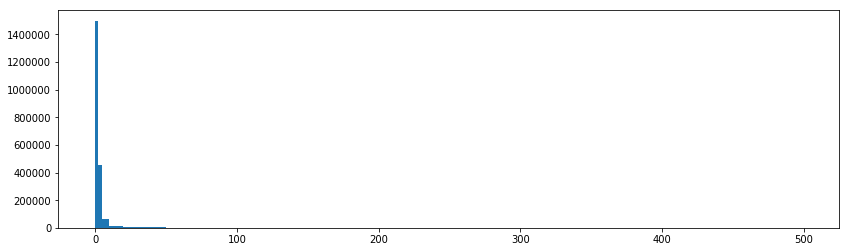

In [11]:
# Quantity histograms

bins = [-1,0,2,5,10,20,50,100,200,500]
fig = plt.figure(figsize=(14,4))
ax1 = fig.add_subplot(111)
ax1.hist(order.quantity, bins=bins)
plt.show()

In [12]:
print('There are total %d trips have quantity larger than 100.'%(len(order[order.quantity > 100])))

There are total 29 trips have quantity larger than 100.


In [13]:
order[order.quantity < 0]

,trip_id,item_id,department_name,quantity
195334,4172377,1436444,Popular,-0.75
403643,3208781,354189,Produce,-0.50


In [14]:
# Data imputation
# Fix smaller than 0 quantity

order.loc[order.quantity < 0, ['quantity']] = 1

### Feature engineering

In [15]:
# Get the total types of items, visited department types and total quantity for each trip.

order_t1 = order.groupby('trip_id')['item_id', 'department_name'].nunique().reset_index()
order_t2 = order.groupby('trip_id').quantity.sum().reset_index()
order_sum = order_t1.merge(order_t2, on='trip_id')
order_sum.rename(columns={'item_id':'item_types', 'department_name':'department_types'}, inplace=True)

In [16]:
# Feature engineering for train_trips and test_trips

train['shopping_started_at'] = pd.to_datetime(train['shopping_started_at'], infer_datetime_format=True)
train['shopping_ended_at'] = pd.to_datetime(train['shopping_ended_at'], infer_datetime_format=True)
test['shopping_started_at'] = pd.to_datetime(test['shopping_started_at'], infer_datetime_format=True)

train['Weekday'] = train['shopping_started_at'].dt.weekday
test['Weekday'] = test['shopping_started_at'].dt.weekday
train['Hour'] = train['shopping_started_at'].dt.hour
test['Hour'] = test['shopping_started_at'].dt.hour

train = train.join(pd.get_dummies(train.Weekday, prefix='Weekday'))
train = train.join(pd.get_dummies(train.Hour, prefix='Hour'))

test = test.join(pd.get_dummies(test.Weekday, prefix='Weekday'))
test = test.join(pd.get_dummies(test.Hour, prefix='Hour'))

train = train.join(pd.get_dummies(train.fulfillment_model, prefix='M'))
test = test.join(pd.get_dummies(test.fulfillment_model, prefix='M'))

train = train.join(pd.get_dummies(train.store_id, prefix='Store'))
test = test.join(pd.get_dummies(test.store_id, prefix='Store'))

In [17]:
# Get training label

def GetDuration(x0, x1):
    
    t = pd.Timedelta(x0 - x1).seconds
    return t

train['Duration'] = train[['shopping_ended_at', 'shopping_started_at']].apply(lambda x: GetDuration(x[0], x[1]), axis = 1)

In [18]:
# Merge to get full dataset for train and test

train = train.merge(order_sum, on='trip_id', how='left')
test = test.merge(order_sum, on='trip_id', how='left')

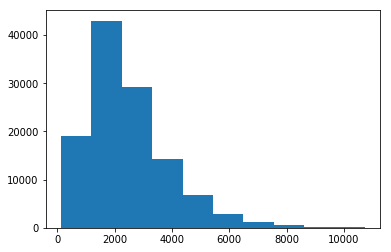

In [19]:
# Get distribution of Duration

counts, bins, fig = plt.hist(train.Duration)

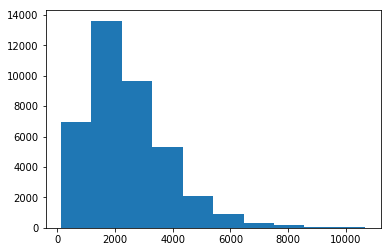

In [20]:
# See whether Duration distribution will be different depending on fulfillment_model.

counts, bins, fig = plt.hist(train[train.fulfillment_model == 'model_1'].Duration)

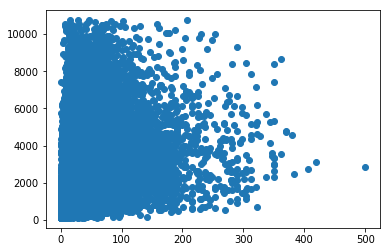

In [21]:
# Explore rationship between quantity and duration

plt.scatter(train.quantity, train.Duration)
plt.show()

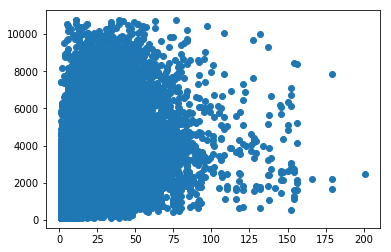

In [22]:
# Explore rationship between item_types and duration

plt.scatter(train.item_types, train.Duration)
plt.show()

In [23]:
# Date duration of the train and test data.

print('For train, min and max time:')
print(train.shopping_started_at.min(), train.shopping_started_at.max())

print('For test, min and max time:')
print(test.shopping_started_at.min(), test.shopping_started_at.max())

For train, min and max time:
2015-09-01 07:03:56 2015-11-15 22:17:32
For test, min and max time:
2015-11-16 07:00:12 2015-11-22 22:09:33


In [24]:
# Add coloumns which are not in test_trips but in train_trips.csv

test['Store_78'] = pd.DataFrame([0 for i in range(len(test))])
test['Store_148'] = pd.DataFrame([0 for i in range(len(test))])
test['Hour_23'] = pd.DataFrame([0 for i in range(len(test))])

In [25]:
train.columns

Index(['trip_id', 'shopper_id', 'fulfillment_model', 'store_id',
       'shopping_started_at', 'shopping_ended_at', 'Weekday', 'Hour',
       'Weekday_0', 'Weekday_1', 'Weekday_2', 'Weekday_3', 'Weekday_4',
       'Weekday_5', 'Weekday_6', 'Hour_7', 'Hour_8', 'Hour_9', 'Hour_10',
       'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15', 'Hour_16',
       'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21', 'Hour_22',
       'Hour_23', 'M_model_1', 'M_model_2', 'Store_1', 'Store_3', 'Store_5',
       'Store_6', 'Store_29', 'Store_31', 'Store_54', 'Store_78', 'Store_90',
       'Store_105', 'Store_115', 'Store_123', 'Store_126', 'Store_148',
       'Duration', 'item_types', 'department_types', 'quantity'],
      dtype='object')

In [26]:
# Feature to use

feature_cols = ['Weekday_0', 'Weekday_1', 'Weekday_2', 'Weekday_3', 'Weekday_4',
       'Weekday_5', 'Weekday_6', 'Hour_7', 'Hour_8', 'Hour_9', 'Hour_10',
       'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15', 'Hour_16',
       'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21', 'Hour_22',
       'Hour_23', 'M_model_1', 'M_model_2', 'Store_1', 'Store_3', 'Store_5',
       'Store_6', 'Store_29', 'Store_31', 'Store_54', 'Store_78', 'Store_90',
       'Store_105', 'Store_115', 'Store_123', 'Store_126', 'Store_148', 
                'item_types', 'department_types', 'quantity']

### Model training, hyperparameter tuning and prediction

In [27]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

In [28]:
train_data = train[['Duration'] + feature_cols]
train_data, test_data = train_test_split(train_data, test_size=0.1)

train_data, train_label = train_data[feature_cols], train_data['Duration']

test_data, test_label = test_data[feature_cols], test_data['Duration']

In [29]:
# Solve problem with xgb error

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [30]:
# Define model parameters and hyperparamter tuning

flag_model = 'xgb'
flag_search = 'random'

xgb = XGBRegressor(n_jobs=-1, silent=1, subsample=0.9, eval_metric='rmse')    
rf = RandomForestRegressor(n_jobs=-1)

if flag_model == 'xgb': 
    model = xgb
    params_grid = {
        "max_depth" : [3, 4, 5, 6, 7],
        "n_estimators": [20, 40, 60, 80, 100, 120, 140],
        "min_child_weight": [1, 3, 5],
        "gamma": [i/10.0 for i in range(3,6)]
         }
    params_random = {
        "max_depth" : [2, 3, 4, 5, 6, 7, 8],
        "n_estimators": [20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160],
        "min_child_weight": [1, 2, 3, 4, 5],
        "gamma": [i/10.0 for i in range(3,6)]
         }
else:
    model = rf
    params_grid = {
    "n_estimators" : [40, 60, 80, 100, 120, 140, 160, 180],
    "max_depth" : [3, 4, 5, 6, 7, 8],
    "min_samples_leaf" : [1, 2, 4],
    "criterion":['mse']  # 'mae' or 'mse'
     }
    params_random = {
    "n_estimators" : [40, 50, 60, 70, 80, 90, 100, 100, 120, 130, 140, 150, 160, 170, 180],
    "max_depth" : [3, 4, 5, 6, 7, 8],
    "min_samples_leaf" : [1, 2, 3, 4, 5],
    "criterion":['mse']  # 'mae' or 'mse'
     }
    
if flag_search == 'grid':
    grid = GridSearchCV(estimator=model, param_grid=params_grid, cv=8)
else:
    grid = RandomizedSearchCV(estimator=model, param_distributions=params_random, cv=8)

grid.fit(train_data, train_label)

print(grid.best_params_)

{'n_estimators': 150, 'min_child_weight': 4, 'max_depth': 6, 'gamma': 0.4}


In [54]:
# Model validation

ypred = grid.best_estimator_.predict(test_data)
df_pred = pd.DataFrame(test_label)
df_pred = df_pred.assign(pred=list(ypred))

In [55]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(df_pred.Duration, df_pred.pred)
print('Mean Squared Error is: %.3f.'%(mse))
r2 = r2_score(df_pred.Duration, df_pred.pred)
print('r2 score is: %.3f.'%(r2))

df_pred.head(3)

Mean Squared Error is: 1319709.031.
r2 score is: 0.355.


,Duration,pred
53502,3840,2061.622559
12345,1560,3568.772217
44858,6480,4492.636230


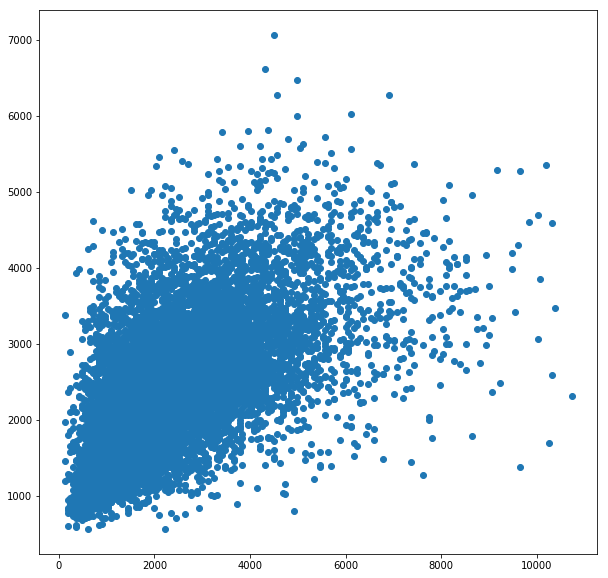

In [56]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)
ax1.scatter(df_pred.Duration, df_pred.pred)
plt.show()

In [57]:
df_pred['diff'] = df_pred['pred'] - df_pred['Duration']
df_pred['abs_diff'] = df_pred['diff'].map(lambda x: abs(x))

In [58]:
print('Percentage larger than 20 mins: ', len(df_pred[df_pred['abs_diff'] > 1200]) / len(df_pred))

Percentage larger than 20 mins:  0.2169642094473392


In [59]:
# Get prediction

final_pred = grid.best_estimator_.predict(test[feature_cols])
final_df = test[['trip_id', 'fulfillment_model', 'store_id', 'item_types', 'department_types', 'quantity']]
final_df = final_df.assign(shopping_time=list(final_pred))
final_df[['trip_id', 'shopping_time']].to_csv('result_submit.csv', index=False)

final_df.head(3)

,trip_id,fulfillment_model,store_id,item_types,department_types,quantity,shopping_time
0,4310899,model_2,123,16,9,28.0,2634.754639
1,4310904,model_2,123,39,15,48.0,3480.924561
2,4310907,model_2,123,18,8,21.0,2582.205078


### Thank You

In [60]:
final_df['shopping_time'] = final_df['shopping_time'].astype('int64')

In [61]:
final_df[['trip_id', 'shopping_time']].to_csv('result_submit.csv', index=False)